# Setup Environment

In [35]:
import random
import os
from tqdm.auto import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


## Download & Check Dataset

In [ ]:
batch_size = 64

# Convert to tensor, normalize ~N(0.5, 0.5 ^ 2)
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

# Download to data/, shuffle when load a batch
train_data = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Images shape: torch.Size([32, 1, 28, 28])
Labels shape: torch.Size([32])

Range: tensor(-1.) ~ tensor(1.)

labels: [6, 6, 1, 8, 7]


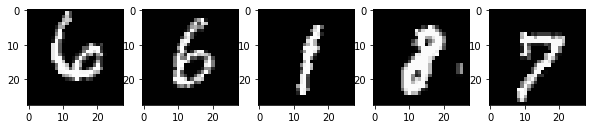

In [ ]:
# Show image shape and value range
images, labels = iter(train_loader).next()
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print()

print('Range:', torch.min(images), '~', torch.max(images))
print()

# Show input samples
n_samples = 5
plt.figure(figsize=(10, n_samples * 10))
for i in range(n_samples):
  image = transforms.ToPILImage()(images[i])

  plt.subplot(1, n_samples, i + 1)
  plt.imshow(image, cmap='gray')

print('labels:', labels[:n_samples].tolist())

# Build Model

## Design Model

### Generator

In [ ]:
# The generator input tensor size
z_size = 100

In [ ]:
def deconv_block(in_channels, out_channels, k, p, s, tails=True):
  '''
  Make a deconvolution block with 
  k kernel_size, p padding equally to both side equally,
  and s strides.

  The optional tail layers are 2D batch norm and 
  leaky relu with 0.2 negative slope.
  '''
  layers = [nn.ConvTranspose2d(in_channels, out_channels, 
                               kernel_size=k, padding=p, stride=s)]
  if tails:
    layers.extend([nn.BatchNorm2d(out_channels),
                   nn.LeakyReLU(0.2),
    ])
  return nn.Sequential(*layers)


class Generator(nn.Module):
  '''
  Input : (n, 100)
  Output: (n, 28 * 28)

  Linear(), BatchNorm1d, LeakyReLU(0.2) -> n x 256 * 7 * 7

  Reshape()                             -> n x 256 x  7 x  7
  Deconv(), BatchNorm2d, LeakyReLU(0.2) -> n x 128 x  7 x  7
  Deconv(), BatchNorm2d, LeakyReLU(0.2) -> n x  64 x 14 x 14
  Deconv(), Tanh()                      -> n x   1 x 28 x 28
  '''
  def __init__(self):  
    super(Generator, self).__init__()

    self.fc = nn.Linear(z_size, 7 * 7 * 256)
    self.fc_bn = nn.BatchNorm1d(self.fc.out_features)
    self.fc_leaky_relu = nn.LeakyReLU(0.2)

    self.deconv1 = deconv_block(256, 128, k=5, p=2, s=1)
    self.deconv2 = deconv_block(128, 64, k=6, p=2, s=2)
    self.deconv3 = deconv_block(64, 1, k=6, p=2, s=2, tails=False)
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.fc(x)
    x = self.fc_bn(x)
    x = self.fc_leaky_relu(x)

    x = x.view(-1, 256, 7, 7)
    x = self.deconv1(x)
    x = self.deconv2(x)
    x = self.deconv3(x)

    out = self.tanh(x)
    return out.view(-1, 28 * 28)

### Discriminator

In [ ]:
def conv_block(in_channels, out_channels, k, p, s):
  '''
  Make a convolution block with 
  k kernel_size, p padding equally to both side equally,
  and s strides.

  The tail layers: 2D batch norm and 
  leaky relu with 0.2 negative slope
  will be attached at the end.
  '''
  layers = [nn.Conv2d(in_channels, out_channels, 
                      kernel_size=k, stride=s, padding=p),
            nn.BatchNorm2d(out_channels),
            layers.append(nn.LeakyReLU(0.2))]
            
  return nn.Sequential(*layers)
  

class Discriminator(nn.Module):
  '''
  Input : (n, 28 * 28)
  Output: (n, 1)

  Reshape()                                         -> n x   1 x 28 x 28
  Conv(k=3, p=1, s=2), BatchNorm2d, LeakyReLU(0.2)  -> n x  32 x 14 x 14
  Conv(k=3, p=1, s=2), BatchNorm2d, LeakyReLU(0.2)  -> n x  64 x  7 x  7
  Conv(k=3, p=1, s=2), BatchNorm2d, LeakyReLU(0.2)  -> n x 128 x  4 x  4
  
  Reshape()                                         -> n x 128 * 4 * 4
  Linear(), Sigmoid()                               -> n x 1
  '''
  def __init__(self):  
    super(Discriminator, self).__init__()
    
    self.conv1 = conv_block(1, 32, k=3, p=1, s=2)
    self.conv2 = conv_block(32, 64, k=3, p=1, s=2)
    self.conv3 = conv_block(64, 128, k=3, p=1, s=2)

    self.fc = nn.Linear(128 * 4 * 4, 1)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    x = x.view(-1, 1, 28, 28)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    
    x = x.view(-1, 128 * 4 * 4)
    x = self.fc(x)
    out = self.sigmoid(x)
    
    return out

## Test
Do an assertion test with the shape after G and D.

In [ ]:
G, D = Generator().to(device), Discriminator().to(device)

sample_x = torch.rand(10, z_size).to(device)
print('I:', sample_x.shape)

G_out = G(sample_x)
print('G:', G_out.shape)
assert G_out.shape == (10, 784)

D_out = D(G_out)
print('D:', D_out.shape)
assert D_out.shape == (10, 1)

del G, D

I: torch.Size([10, 100])
G: torch.Size([10, 784])
D: torch.Size([10, 1])


In [ ]:
def make_model(init = True):
  D = Discriminator().to(device)
  G = Generator().to(device)

  # Initialize weights if required.
  if init:
    def init_weight(module: nn.Module):
      for param in module.parameters():
        if param.ndim > 1:
          torch.nn.init.xavier_normal_(param)

    D.apply(init_weight)
    G.apply(init_weight)

  lr = 1.0E-4
  d_optimizer = optim.Adam(D.parameters(), lr)
  g_optimizer = optim.Adam(G.parameters(), lr)

  return D, G, d_optimizer, g_optimizer

# Train Model

## Build Architecture

In [ ]:
criterion = nn.BCELoss().to(device)


def make_z(size):
  '''
  Make random inputs.
  '''
  return torch.randn(size, z_size).to(device)


def make_labels(size, value):
  '''
  Make labels with specified value.
  '''
  return torch.ones(size, 1).to(device) * value


def train_D(G, D, optimizer, real_images):
  '''
  Train the discriminator.
  '''
  # Generate fake images as much as real images.
  num_images = real_images.size(0)
  z = make_z(num_images)
  fake_images = G(z)

  # Discriminate real and fake images.
  out_real = D(real_images)
  out_fake = D(fake_images.detach())  # detach !!!

  # Calculate the discriminator loss.
  loss_real = criterion(out_real, make_labels(out_real.size(0), 1))
  loss_fake = criterion(out_fake, make_labels(out_fake.size(0), 0))
  loss = loss_real + loss_fake

  # Train the loss.
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss_real.detach(), loss_fake.detach()


def train_G(G, D, optimizer):
  '''
  Train the generator.
  '''
  # Generate fake images.
  z = make_z(batch_size)
  images = G(z)

  # Caluclate the loss.
  out = D(images)
  loss = criterion(out, make_labels(batch_size, 1))

  # Train the loss.
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return loss.detach()


def demonstrate(G, num_samples):
  '''
  Shows some sample images from generator.
  '''
  with torch.no_grad():
    z = torch.rand(num_samples, z_size).to(device)

    out = G(z).view(-1, 1, 28, 28).cpu()
    plt.figure(figsize=(8, num_samples * 8))
    for i in range(num_samples):
      img = transforms.ToPILImage()(out[i])

      plt.subplot(1, num_samples, i + 1)
      plt.imshow(img, cmap='gray')

    plt.show()


# Test one epoch.
# This test will NOT affect the actual training.
D, G, d_optimizer, g_optimizer = make_model()
print('[Epoch test]')

print('Discriminator... ', end='')
train_D(G, D, d_optimizer, torch.rand(8, 1, 28, 28).to(device))
print('done')

print('Generator... ', end='')
train_G(G, D, g_optimizer)
print('done')

del D, G, d_optimizer, g_optimizer

[Epoch test]
Discriminator... done
Generator... done


## Load History
- Loss history
- State dicts
- Epoch info

In [ ]:
# Ready for saving, loading the result.
output_path = './history'
loss_file_name = f'{output_path}/loss.tar'

# Set true if you want to load {start_epoch - 1}th parameters.
load_history = False

if not os.path.exists(output_path):
  os.mkdir(output_path)

# Make discriminator and generator with their optimizers.
D, G, d_optimizer, g_optimizer = make_model()
loss_list = {'epoch': 0, 'real': [], 'fake': [], 'generator': []}
start_epoch, end_epoch = 1, 20

if load_history:
  if os.path.exists(loss_file_name):
    loss_list = torch.load(loss_file_name)
    last_epoch = loss_list['epoch']

    # Load parameters if exists.
    if os.path.exists(f'{output_path}/{start_epoch - 1}.tar'):
      state_dicts = torch.load(f'{output_path}/{start_epoch - 1}.tar')
      G.load_state_dict(state_dicts['G'], strict=True)
      D.load_state_dict(state_dicts['D'], strict=True)
else:
  %rm -r {output_path}/*

## Train

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 1: real=0.29685816168785095, fake=0.3159487843513489, gen=1.9412068128585815


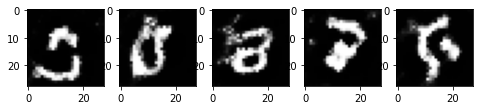

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 2: real=0.32379093766212463, fake=0.313819020986557, gen=1.751706600189209


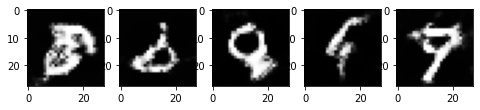

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 3: real=0.3066946864128113, fake=0.29788488149642944, gen=1.6952670812606812


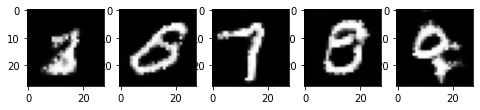

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 4: real=0.26156848669052124, fake=0.2533116042613983, gen=1.88821542263031


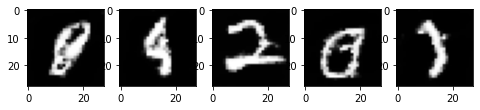

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 5: real=0.2540671229362488, fake=0.2449263483285904, gen=1.9936906099319458


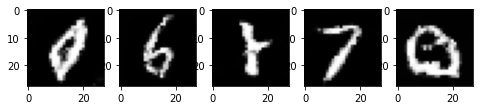

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 6: real=0.24980811774730682, fake=0.24019567668437958, gen=2.065423011779785


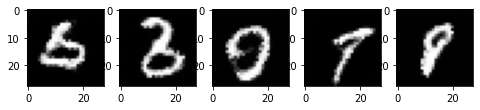

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 7: real=0.24984343349933624, fake=0.23867113888263702, gen=2.0890777111053467


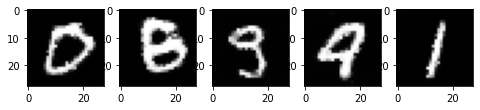

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 8: real=0.24549591541290283, fake=0.23705032467842102, gen=2.1384685039520264


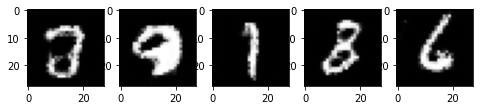

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 9: real=0.23982712626457214, fake=0.23345889151096344, gen=2.160834312438965


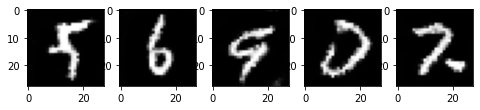

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 10: real=0.2430228441953659, fake=0.23577027022838593, gen=2.200913190841675


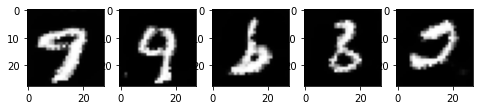

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 11: real=0.23471415042877197, fake=0.2294100522994995, gen=2.2211530208587646


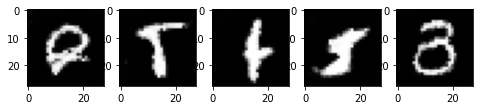

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 12: real=0.23934608697891235, fake=0.23199431598186493, gen=2.2449541091918945


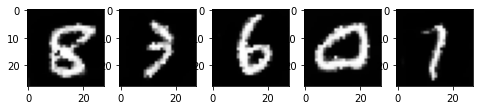

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 13: real=0.23163706064224243, fake=0.2257140576839447, gen=2.2455320358276367


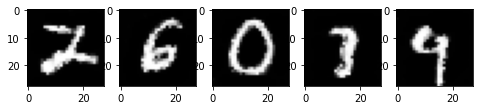

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 14: real=0.23139239847660065, fake=0.22511574625968933, gen=2.2679190635681152


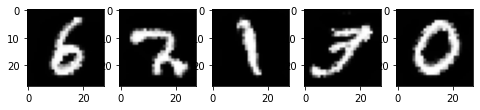

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 15: real=0.22658702731132507, fake=0.2206525206565857, gen=2.29494047164917


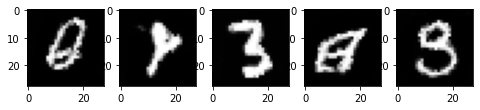

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 16: real=0.2298298478126526, fake=0.22417069971561432, gen=2.342207431793213


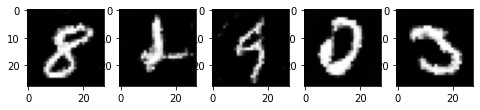

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 17: real=0.23347878456115723, fake=0.22930732369422913, gen=2.308614492416382


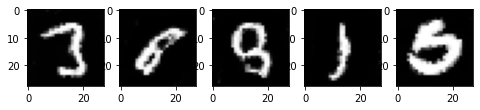

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 18: real=0.2300136685371399, fake=0.22546184062957764, gen=2.347740888595581


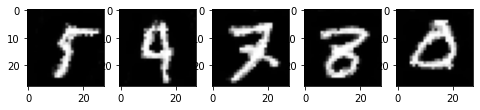

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 19: real=0.2357146292924881, fake=0.22885669767856598, gen=2.3237128257751465


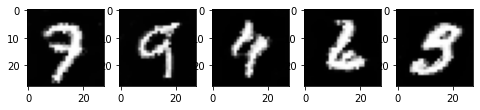

  0%|          | 0/1875 [00:00<?, ?it/s]

epoch 20: real=0.23538899421691895, fake=0.23013897240161896, gen=2.3204686641693115


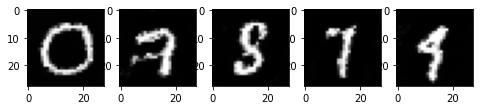

In [ ]:
for epoch in range(start_epoch, end_epoch + 1):
  r_loss, f_loss = 0, 0
  g_loss = 0
  for real_images, _ in tqdm(train_loader):
    real_images = real_images.to(device)

    # Train a batch.
    real_loss, fake_loss = train_D(G, D, d_optimizer, real_images)
    gen_loss = train_G(G, D, g_optimizer)

    # Average loss
    r_loss += real_loss / len(train_loader)
    f_loss += fake_loss / len(train_loader)
    g_loss += gen_loss / len(train_loader)

  # Save this epoch.
  loss_list['epoch'] = epoch
  loss_list['real'].append(r_loss.item())
  loss_list['fake'].append(f_loss.item())
  loss_list['generator'].append(g_loss.item())

  state_dicts = {'D': D.state_dict(), 'G': G.state_dict()}

  torch.save(loss_list, loss_file_name)
  torch.save(state_dicts, f'{output_path}/{epoch}.tar')

  # Print this epoch, demonstrate.
  print(f'epoch {epoch}: real={r_loss}, fake={f_loss}, gen={g_loss}')
  demonstrate(G, 5)
  print()


## Export Result

In [ ]:
from datetime import datetime
from dateutil.tz import gettz
from google.colab import drive
drive.mount('/content/drive')


def timestamp():
  '''
  Return formatted now: yyyyMMdd_hhmmss.
  '''
  now = datetime.now(gettz('Asia/Seoul'))
  return '%d%02d%02d_%02d%02d%02d' % (now.year, now.month, now.day, 
                                      now.hour, now.minute, now.second)


# Export all history to specified directory.
export_to = f'/content/drive/MyDrive/Projects/MNIST_GAN/{timestamp()}/'
# export_to = None

if export_to is not None:
  if os.path.exists(export_to):
    %rm -rf {export_to}
  
  os.mkdir(export_to)
  %cp -r {output_path}/* {export_to}
  print('Successfully exported.')

Mounted at /content/drive
Successfully exported.


# Evaluate

## Show Loss

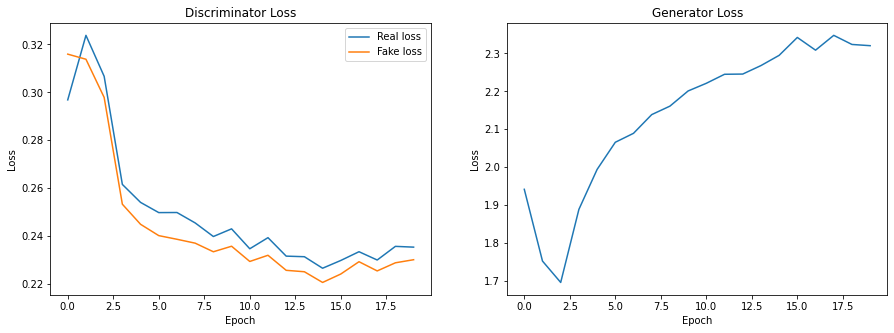

In [33]:
total_epoch = loss_list['epoch']
x = torch.arange(total_epoch)

real_loss = loss_list['real']
fake_loss = loss_list['fake']
gen_loss = loss_list['generator']

plt.figure(figsize=(15, 5))
# Show real loss and fake loss in one chart
plt.subplot(1, 2, 1)
plt.title('Discriminator Loss')
plt.plot(x, real_loss, label='Real loss')
plt.plot(x, fake_loss, label='Fake loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show generator loss separately
plt.subplot(1, 2, 2)
plt.title('Generator Loss')
plt.plot(x, gen_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Generate Result

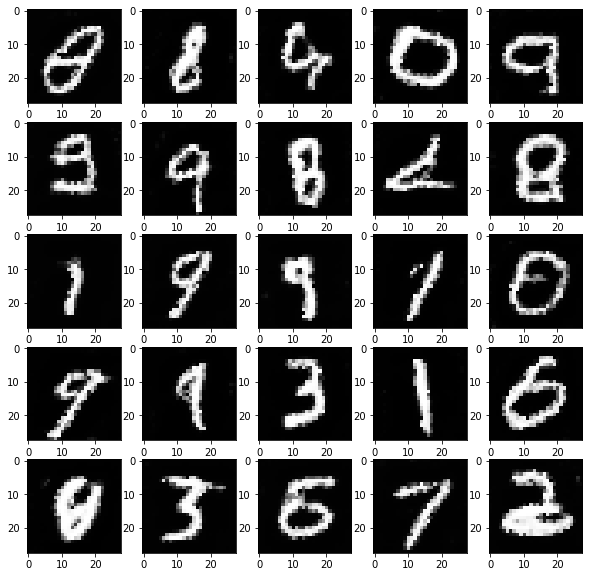

In [34]:
a = 5
z = torch.randn(a * a, z_size).to(device)

out = G(z).view(-1, 1, 28, 28).cpu()
plt.figure(figsize=(a * 2, a * 2))
for i in range(a * a):
  img = transforms.ToPILImage()(out[i])

  plt.subplot(a, a, i + 1)
  plt.imshow(img, cmap='gray')
plt.show()

In [56]:
generator = Generator().to(device)
z = make_z(25)

num_epochs = loss_list['epoch']
layers = []
for i in tqdm(range(1, num_epochs + 1)):
  file_name = f'{output_path}/{i}.tar'
  state_dict = torch.load(file_name)['G']

  generator.load_state_dict(state_dict, strict=True)
  images = generator(z).view(-1, 1, 28, 28)

  image = torch.cat([torch.cat([images[r + c] for c in range(0, 5, 1)], dim=2) for r in range(0, 25, 5)], dim=1)
  image = transforms.ToPILImage()(image)

  layers.append(image)

layers.extend([layers[-1] for i in range(4)])

image = layers[0]
image.save(f'{output_path}/out.gif', save_all=True, append_images=layers[1:], loop=0xff, duration=250)
  
del generator

  0%|          | 0/20 [00:00<?, ?it/s]